In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal, Categorical
import sys
%load_ext autoreload
%autoreload 2
sys.path.append('../scripts/')
from agents import GNN, Critic
from environment import CustomEnvironment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# TODO: convert to script, write PPO class, push and pull to/from repo, move to HPC, change reward weights, Render to sanity check schedules produced

In [49]:
from torch.utils.tensorboard import SummaryWriter

In [50]:
writer = SummaryWriter()

In [51]:
lr = 0.001
actor = GNN()
critic = Critic()
actor_optim = Adam(actor.parameters(), lr=lr)
critic_optim = Adam(critic.parameters(), lr=lr)

max_total_timesteps=10000
max_timesteps_per_batch=1000
k = 3  # num updates per batch
gamma = 0.95 # discount factor
clip = 0.2 # clip ratio min and max

In [52]:
# Init env
env = CustomEnvironment() # default env
env.set_params()
env.timestep=50

In [53]:
# data, _, _, _ = env.reset()
# _, reward, _, _ = env.step(torch.argmax(actor(data)).item())
# print(reward)

In [54]:
def get_action_log_prob(data):
    edge_probs = actor(data)    # prob of each edge, Ex1
    disp = Categorical(edge_probs)
    action = disp.sample()
    log_prob = disp.log_prob(action)
    return action, log_prob # tensor, tensor w/ grad_fn

In [55]:
def get_current_value_log_prob(batch_data, batch_acts):
    # NOTE: cannot apply actor in aggregate to batch_data because of HeteroData constraints
    curr_log_probs = [Categorical(actor(data)).log_prob(batch_acts[i]) for i,data in enumerate(batch_data)]
    curr_V = [critic(data) for data in batch_data]
    # NOTE: do not detach
    return torch.stack(curr_V), torch.stack(curr_log_probs)

In [56]:
def compute_rtgs(batch_rewards: list[list]):
    batch_rtgs = []
    for ep_rewards in reversed(batch_rewards):
        discounted_reward = 0
        for reward in reversed(ep_rewards):
            discounted_reward = reward + discounted_reward * gamma
            batch_rtgs.insert(0, discounted_reward)
    return batch_rtgs # TODO: unsure why it becomes list of tensors instead of list of floats

In [57]:
# torch.autograd.set_detect_anomaly(True)

In [64]:
def rollout():
    batch_t = 0 # batch timesteps
    batch_rewards, batch_data, batch_v, batch_acts, batch_log_probs = [],[],[],[],[]
    while batch_t < max_timesteps_per_batch:
        # start new episode
        ep_reward = []
        data, _, _, _ = env.reset()
        for _ in range(env.max_timesteps):
            batch_t +=1

            # Append data
            batch_data.append(data.clone()) # NOTE: really not ideal for memory

            # Calculate estimated value
            batch_v.append(critic(data))

            # Calculate action, log_prob
            action, log_prob = get_action_log_prob(data)
            action = action.item()
            log_prob = log_prob.detach().item()
            batch_acts.append(action)
            batch_log_probs.append(log_prob)

            # Take step
            data, reward, _, _ = env.step(action)

            # Collect step reward
            ep_reward.append(reward)

            if env.termination:
                break
        batch_rewards.append(ep_reward)

    # At end of batch
    # Calculate rewards-to-go
    batch_rtgs = compute_rtgs(batch_rewards)

    # Convert to tensors
    batch_v = torch.stack(batch_v)                  # use stack to preserved grad_fn
    batch_rtgs = torch.tensor(batch_rtgs)
    batch_log_probs = torch.tensor(batch_log_probs)
    batch_acts = torch.tensor(batch_acts)

    return batch_data, batch_v, batch_acts, batch_log_probs, batch_rtgs, batch_rewards

In [ ]:
total_t = 0
rewards = []
total_b = 0
while total_t < max_total_timesteps:
    # Create a new batch of length T = max_timesteps_per_batch
    total_b += 1
    print("Batch ", total_b, " is ", total_t, " timesteps in")
    batch_data, batch_v, batch_acts, batch_log_probs, batch_rtgs, batch_rewards = rollout()
    rewards += batch_rewards
    total_t += max_timesteps_per_batch

    # Calculate advantage
    A_k = (batch_rtgs - batch_v.detach()) # NOTE: does this detach V permanently?
    A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)
    
    # Update k times per batch
    for _ in range(k):
        curr_V, curr_log_probs = get_current_value_log_prob(batch_data, batch_acts)

        # Calculate ratios
        ratios = torch.exp(curr_log_probs - batch_log_probs)

        # Calculate surrogate losses
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1 - clip, 1 + clip)

        actor_loss = (-torch.min(surr1, surr2)).mean()
        critic_loss = nn.MSELoss()(curr_V, batch_rtgs)

        actor_optim.zero_grad()
        actor_loss.backward(retain_graph=True)
        actor_optim.step()

        critic_optim.zero_grad()
        critic_loss.backward()
        critic_optim.step()

In [66]:
rewards_arr = np.array(rewards)
rewards_arr = rewards_arr.reshape((rewards_arr.size))

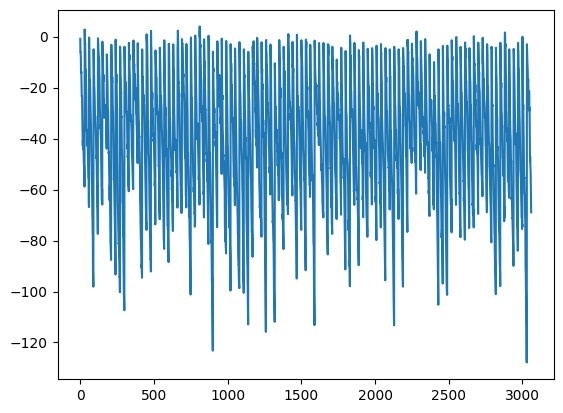

In [67]:
plt.plot(np.arange(len(rewards_arr)), rewards_arr)

In [126]:
total_t = 0
total_e = 0
total_b = 0
while total_t < max_total_timesteps:
    # Create a new batch of length T = max_timesteps_per_batch
    total_b += 1
    batch_t = 0
    batch_rewards = []
    batch_data, batch_v, batch_acts, batch_log_probs, batch_rtgs = [],[],[],[],[]
    # hetero_data, tensor w/ grad, int, float, float
    while batch_t < max_timesteps_per_batch and total_t < max_total_timesteps:
        total_e += 1
        print("Batch ", total_b, ", Episode ", total_e, " started at timestep ", total_t)
        ep_reward = []
        data, reward, _, _ = env.reset()
        for _ in range(env.max_timesteps):
            batch_t +=1
            total_t +=1

            # Append data
            batch_data.append(data.clone()) # NOTE: really not ideal for memory

            # Calculate estimated value
            batch_v.append(critic(data))

            # Calculate action, log_prob
            action, log_prob = get_action_log_prob(data)
            action = action.item()
            log_prob = log_prob.detach().item()
            batch_acts.append(action)
            batch_log_probs.append(log_prob)

            # Take step
            data, reward, _, _ = env.step(action)
            
            # Collect step reward
            ep_reward.append(reward)

            if env.termination:
                data, reward, _, _ = env.reset()
        batch_rewards.append(ep_reward)

    # Calculate rewards-to-go
    batch_rtgs = compute_rtgs(batch_rewards)

    # Convert to tensors
    batch_V = torch.stack(batch_v)                  # use stack to preserved grad_fn
    batch_rtgs = torch.tensor(batch_rtgs)
    batch_log_probs = torch.tensor(batch_log_probs)
    batch_acts = torch.tensor(batch_acts)

    # Calculate advantage
    A_k = (batch_rtgs - batch_V.detach()) # NOTE: does this detach V permanently?
    A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)
    
    # Update k times per batch
    for _ in range(k):
        curr_V, curr_log_probs = get_current_value_log_prob(batch_data, batch_acts)

        # Calculate ratios
        ratios = torch.exp(curr_log_probs - batch_log_probs)

        # Calculate surrogate losses
        surr1 = ratios * A_k
        surr2 = torch.clamp(ratios, 1 - clip, 1 + clip)

        actor_loss = (-torch.min(surr1, surr2)).mean()
        critic_loss = nn.MSELoss()(curr_V, batch_rtgs)

        actor_optim.zero_grad()
        actor_loss.backward(retain_graph=True)
        actor_optim.step()

        critic_optim.zero_grad()
        critic_loss.backward()
        critic_optim.step()


Batch  1 , Episode  1  started at timestep  0


/Users/durdledoor/Library/Mobile Documents/com~apple~CloudDocs/2024_Projects/art-heist/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Batch  1 , Episode  2  started at timestep  30


/Users/durdledoor/Library/Mobile Documents/com~apple~CloudDocs/2024_Projects/art-heist/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Batch  1 , Episode  3  started at timestep  60


/Users/durdledoor/Library/Mobile Documents/com~apple~CloudDocs/2024_Projects/art-heist/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Batch  1 , Episode  4  started at timestep  90


/Users/durdledoor/Library/Mobile Documents/com~apple~CloudDocs/2024_Projects/art-heist/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [130]:
data, _, _, _ = env.reset()
_, reward, _, _ = env.step(torch.argmax(actor(data)).item())
print(reward)

1.1502103805541992


/Users/durdledoor/Library/Mobile Documents/com~apple~CloudDocs/2024_Projects/art-heist/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
# class PPO:
#     def __init__(self, env):
#         # Get environment information
#         self.env = env
#         self.thief_size = env.thief_size
#         self.slot_size = env.slot_size
#         self.heist_size = env.heist_size
#         self._init_hyperparameters()

#         # Init networks
#         self.actor = GNN() # default channels
#         self.critic = Critic()

#         self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=0.001)
#         self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=0.001)

#     def learn(self, total_timesteps):
#         t_so_far = 0
#         while t_so_far < total_timesteps:
#             batch_acts, batch_rtgs, batch_len = self.rollout()
#             t_so_far += np.sum(batch_len)

#             # Calculate V_{phi, k}
#             V, _ = self.evaluate(batch_obs, batch_acts)

#             # Calculate advantage
#             A_k = batch_rtgs - V.detach()

#             # Normalize advantages
#             A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)

#             for _ in range(self, self.n_updates_per_iteration):
#                 # Calculate V_phi and pi_theta(a_t | s_t)
#                 _, curr_log_probs = self.evaluate(batch_obs, batch_acts)

#                 # Calculate ratios
#                 ratios = torch.exp(curr_log_probs - batch_log_probs)

#                 # Calculate surrogate losses
#                 surr1 = ratios * A_k
#                 surr2 = torch.clamp(ratios, 1 - self.clip, 1 + self.clip)

#                 actor_loss = (-torch.min(surr1, surr2)).mean()
#                 critic_loss = nn.MSELoss()(V, batch_rtgs)

#                 self.actor_optim.zero_grad()
#                 actor_loss.backward(retain_graph=True)
#                 self.actor_optim.step()

#                 self.critic_optim.zero_grad()
#                 critic_loss.backward()
#                 self.critic_optim.step()

#     def rollout(self):
#         # Batch data
#         # batch_obs = []          # batch data, too big to store
#         batch_acts = []         # batch actions
#         # batch_log_probs = []    # batch log_probs, too big to store
#         batch_rewards = []      # batch reward
#         batch_rtgs = []         # batch reward to gos
#         batch_lens = []         # batch episode lengths

#         t= 0
#         while t <  self.timesteps_per_batch:
#             ep_rewards = []
#             data, reward, _, _ = self.env.reset()
#             done=False
#             while not env.termination:
#                 # Increment timesteps ran this batch so far
#                 t += 1
#                 # Collect observation
#                 action, log_prob = self.get_action(data)
#                 next_data, reward, _, _ = self.env.step(action)

#                 # Collect reward, action, and log_prob
#                 ep_rewards.append(reward)
#                 batch_acts.append(action)

#                 if done: break
            
#             # Collect episodic length and reward
#             batch_lens.append(self.env.timestep)
#             batch_rewards.append(ep_rewards)
        
#         # Return batch data
#         batch_rtgs = self.compute_rtgs(batch_rewards)
#         return batch_acts, batch_rtgs, batch_lens
    
#     def get_action(self, data):
#         edge_probs = self.actor(data)

#         # sample action # NOTE: hard b/c E changes every step
#         dist = Categorical(edge_probs)
#         action = dist.sample()
#         log_prob = dist.log_prob(action)
#         return action, log_prob.detach().numpy()
    
#     def compute_rtgs(self, batch_rewards):
#         # shape: num timesteps per episode
#         batch_rtgs = []
#         for ep_rewards in reversed(batch_rewards):
#             discounted_reward = 0
#             for reward in reversed(ep_rewards):
#                 discounted_reward = reward + discounted_reward * self.gamma
#                 batch_rtgs.insert(0, discounted_reward)
#         return batch_rtgs
    
#     def _init_hyperparameters(self):
#         # default hyperparameters
#         self.gamma = 0.95
#         self.timesteps_per_batch = 5

#     def evaluate(self, batch_obs, batch_acts):
#         V = self.critic(batch_obs).squeeze()
#         dist = Categorical(self.actor(batch_obs))
#         action = dist.sample()
#         log_probs = dist.log_prob(action)
#         return V, log_probs

In [91]:
test = []
for i in range(5):
    action = torch.argmax(actor(data)).item()
    data, _, _, _ = env.step(action)
    test.append(data)

/Users/durdledoor/Library/Mobile Documents/com~apple~CloudDocs/2024_Projects/art-heist/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [11]:
model = GNN()

In [13]:
data, _, _, _ = env.reset()

In [19]:
edge_probs = model(data)

/Users/durdledoor/Library/Mobile Documents/com~apple~CloudDocs/2024_Projects/art-heist/venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [53]:
# cov = torch.diag(torch.full(size=(len(edge_probs),), fill_value=0.5))
# dist = MultivariateNormal(edge_probs, cov)
# action_probs = dist.sample()
# log_probs = dist.log_prob(action_probs)

In [ ]:
import gym
env = gym.make('Pendulum-v0')
model = PPO(env)
model.learn(10000)